In [3]:
%cd /content/drive/MyDrive/Data/Classification

/content/drive/MyDrive/Data/Classification


# IMAGE CLASSIFICATION WITH HoG AND SVM

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
# from skimage import feature
# from skimage.transform import resize

In [8]:



def process_image(image):
  if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = image.astype(np.float32)
  image = resize(
      image,
      output_shape = (256, 256),
      anti_aliasing = True
  )
  hog_feature = feature.hog(
      image,
      orientations = 9,
      pixels_per_cell = (8, 8),
      cells_per_block = (2, 2),
      transform_sqrt = True,
      block_norm = "L2",
      feature_vector = True,
  )
  return hog_feature


In [17]:
# Tạo tập dữ liệu từ thuật toán HoG


def create_dataset(folder_path, label):
  hog_features = []
  labels = []
  images_name = os.listdir(folder_path)
  for image_name in images_name:
    img =  cv2.imread(os.path.join(folder_path, image_name))
    hog_feature = process_image(img)
    hog_features.append(hog_feature)
    labels.append(label)
  return hog_features, labels

# Ảnh Xuôi
corrected_hog_features, corrected_labels = create_dataset('corrected', 0)
# Ảnh ngược
reverse_hog_features, reverse_labels = create_dataset('reverse', 1)


hog_features  = corrected_hog_features.extend(reverse_hog_features)
labels = corrected_labels.extend(reverse_labels)



In [27]:
hog_features = np.array(corrected_hog_features)
labels = np.array(corrected_labels)

In [33]:
# Chia tập dữ liệu thành train, test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    hog_features, labels,
    test_size = 0.2,
    stratify = labels,
    random_state = 42
)

In [34]:
# Train thuật toán SVM
from sklearn.svm import SVC

model = SVC(kernel = 'rbf')
model.fit(X_train, Y_train)

SVC()

In [35]:
# Đánh giá trên tập dữ liệu test
from sklearn.metrics import accuracy_score
Y_pred = model.predict(X_test)
print(accuracy_score(Y_test, Y_pred))


0.8951965065502183


# IMAGE CLASSIFICATION WITH EFFICIENTNET

In [1]:
# !pip install torch torchvision efficientnet-pytorch


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=c4cf860c722fbc97121ecba358237de647b4e7e7aebfda6207205070caf5b143
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [2]:
print(len(os.listdir('corrected')))
print(len(os.listdir('reverse')))

462
680


In [22]:
import torch
import os
import numpy as np
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet

training_img = []
training_label = []
valid_img = []
valid_label = []
for image_name in os.listdir('corrected'):
  img = cv2.imread(os.path.join('corrected', image_name))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
  img /= 255.0
  img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
  img = torch.FloatTensor(img).permute(2,0,1)
  if len(valid_img) <= 0.2 * len(os.listdir('corrected')):
    valid_img.append(img)
    valid_label.append(0)
  else:
    training_img.append(img)
    training_label.append(0)


for image_name in os.listdir('reverse'):
  img = cv2.imread(os.path.join('reverse', image_name))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
  img /= 255.0
  img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
  img = torch.FloatTensor(img).permute(2,0,1)
  if len(valid_img) <= 0.2 * len(os.listdir('reverse')):
    valid_img.append(img)
    valid_label.append(1)
  else:
    training_img.append(img)
    training_label.append(1)

training_img = np.array(training_img)
training_label = np.array(training_label)
valid_img =np.array(valid_img)
valid_label = np.array(valid_label)


In [23]:
print(training_img.shape)
print(valid_img.shape)

(1005, 3, 256, 256)
(137, 3, 256, 256)


In [24]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class Dataset(Dataset):
  def __init__(self, imgs, labels, transform = None):
    self.imgs = imgs
    self.labels = labels
    self.transform = transform
  def __len__(self):
    return len(self.imgs)
  def __getitem__(self, index):
    image = self.imgs[index]
    label = self.labels[index]
    return image, label



# Tạo dataset
training_dataset = Dataset(training_img, training_label)
valid_dataset = Dataset(valid_img, valid_label)

# Tạo DataLoader

train_loader = DataLoader(training_dataset, batch_size = 8, shuffle=True, num_workers = 1)
valid_loader = DataLoader(valid_dataset, batch_size = 8, shuffle=True, num_workers = 1)

In [25]:
# Tạo mô hình
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=2)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Định nghĩa hàm mất mát và tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 50
# Huấn luyện mô hình
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Tiến trình truyền
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Cập nhật trọng số
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')

# Đánh giá mô hình
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images, labels = images.to('cuda' if torch.cuda.is_available() else 'cpu'), labels.to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the validation set: {100 * correct / total:.2f}%')

Loaded pretrained weights for efficientnet-b4
Epoch [1/50], Loss: 0.3788
Epoch [2/50], Loss: 0.1041
Epoch [3/50], Loss: 0.0503
Epoch [4/50], Loss: 0.0441
Epoch [5/50], Loss: 0.0258
Epoch [6/50], Loss: 0.0173
Epoch [7/50], Loss: 0.0069
Epoch [8/50], Loss: 0.0032
Epoch [9/50], Loss: 0.0024
Epoch [10/50], Loss: 0.0024
Epoch [11/50], Loss: 0.0013
Epoch [12/50], Loss: 0.0032
Epoch [13/50], Loss: 0.0102
Epoch [14/50], Loss: 0.0265
Epoch [15/50], Loss: 0.0042
Epoch [16/50], Loss: 0.0121
Epoch [17/50], Loss: 0.0043
Epoch [18/50], Loss: 0.0010
Epoch [19/50], Loss: 0.0035
Epoch [20/50], Loss: 0.0005
Epoch [21/50], Loss: 0.0004
Epoch [22/50], Loss: 0.0007
Epoch [23/50], Loss: 0.0007
Epoch [24/50], Loss: 0.0004
Epoch [25/50], Loss: 0.0004
Epoch [26/50], Loss: 0.0004
Epoch [27/50], Loss: 0.0002
Epoch [28/50], Loss: 0.0002
Epoch [29/50], Loss: 0.0090
Epoch [30/50], Loss: 0.0363
Epoch [31/50], Loss: 0.0077
Epoch [32/50], Loss: 0.0351
Epoch [33/50], Loss: 0.0095
Epoch [34/50], Loss: 0.0060
Epoch [35/5

In [26]:

model_path = 'weightinvoiced_weight1.pth'
torch.save(model.state_dict(), model_path)

In [27]:
#Kiểm tra dự đoán trên 1 mẫu


img = cv2.imread('corrected/mcocr_public_145013aagqw.jpg')
img = cv2.rotate(img, cv2.ROTATE_180)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img /= 255.0
img = cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA)
img = torch.FloatTensor(img).permute(2,0,1).unsqueeze(0)
img = img.to('cuda')
result = model(img)
result = torch.softmax(result, -1)

result = torch.argmax(result).item()


In [31]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=2)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

Loaded pretrained weights for efficientnet-b4


In [32]:
model.load_state_dict(torch.load('weightinvoiced_weight1.pth'))


/tmp/ipykernel_1393840/1249554113.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weightinvoiced_weight1.pth'))


<All keys matched successfully>

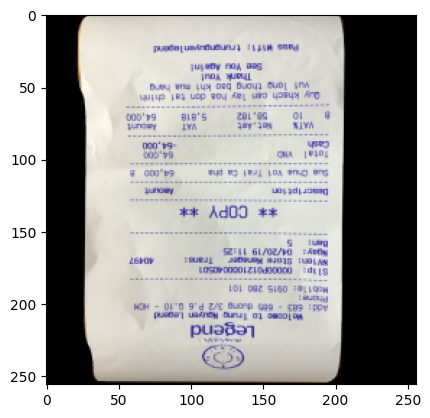

tensor(0.9868, device='cuda:0', grad_fn=<SelectBackward0>)


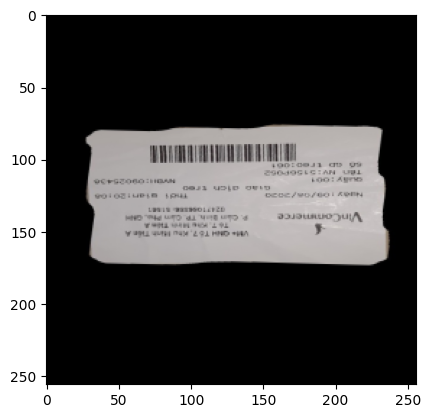

tensor(0.9859, device='cuda:0', grad_fn=<SelectBackward0>)


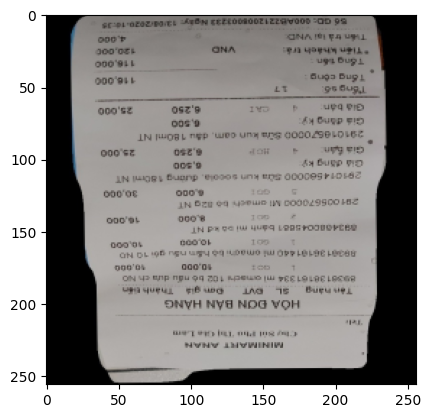

tensor(0.9854, device='cuda:0', grad_fn=<SelectBackward0>)


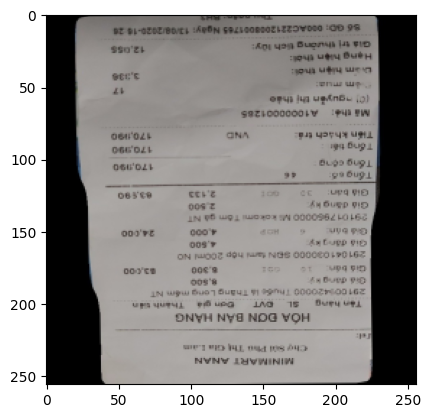

tensor(0.9802, device='cuda:0', grad_fn=<SelectBackward0>)


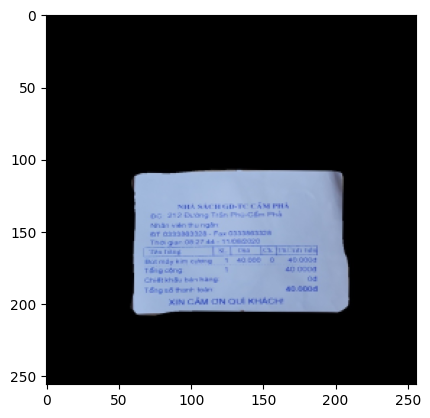

tensor(0.0427, device='cuda:0', grad_fn=<SelectBackward0>)


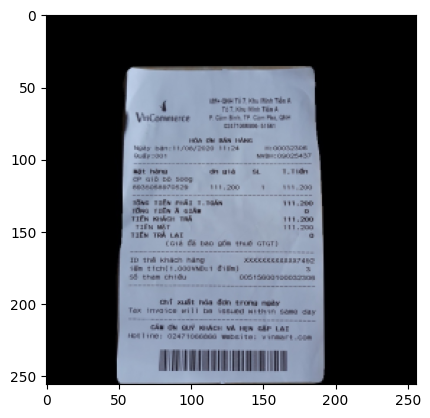

tensor(0.0044, device='cuda:0', grad_fn=<SelectBackward0>)


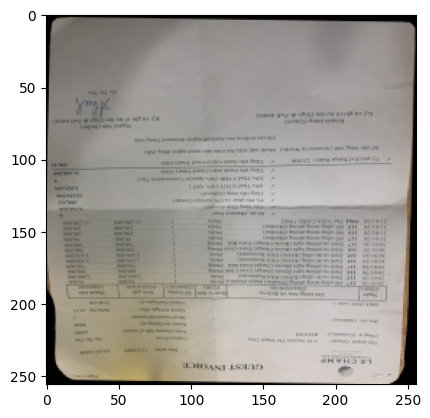

tensor(0.9854, device='cuda:0', grad_fn=<SelectBackward0>)


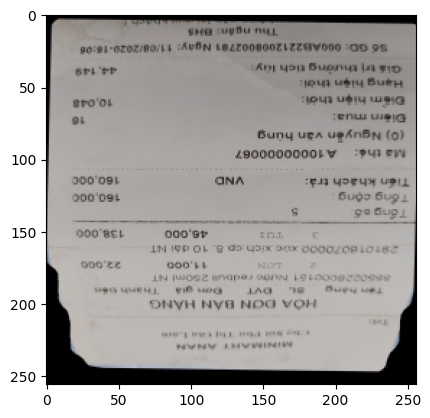

tensor(0.9887, device='cuda:0', grad_fn=<SelectBackward0>)


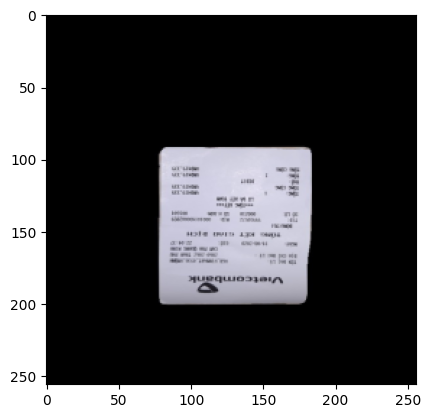

tensor(0.9570, device='cuda:0', grad_fn=<SelectBackward0>)


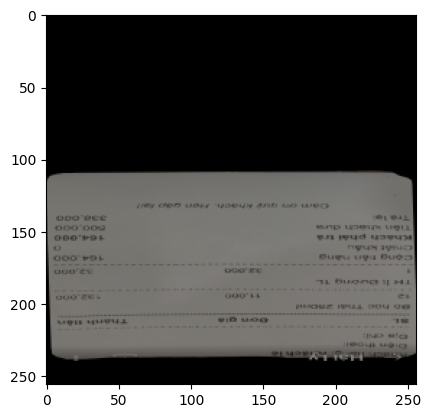

tensor(0.9884, device='cuda:0', grad_fn=<SelectBackward0>)


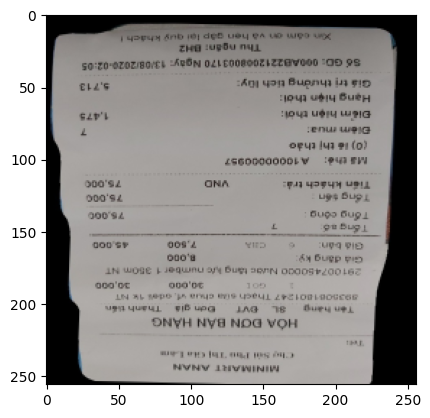

tensor(0.9798, device='cuda:0', grad_fn=<SelectBackward0>)


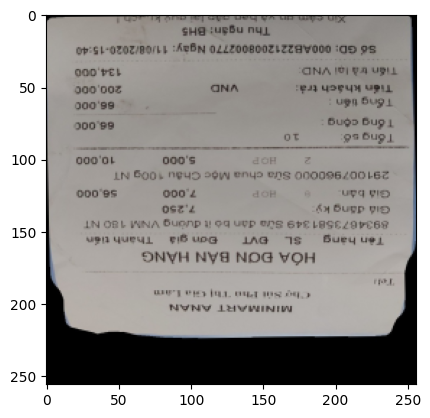

tensor(0.9681, device='cuda:0', grad_fn=<SelectBackward0>)


In [49]:
import matplotlib.pyplot as plt
res = []
for im_name  in os.listdir('reverse'):
    path = os.path.join('reverse', im_name)
    img = cv2.imread(path)
    # img = cv2.rotate(img, cv2.ROTATE_180)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img /= 255.0
    img = cv2.resize(img,(256,256),interpolation=cv2.INTER_AREA)
    img = torch.FloatTensor(img).permute(2,0,1).unsqueeze(0)
    img = img.to('cuda')
    result = model(img)
    result = torch.softmax(result, -1)
    if result[0][1] < 0.96:
        plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().numpy())
        plt.show()
        print(result[0][1])
    result = torch.argmax(result).item()
    res.append(result)